<h1>Восстановление золота из руды</h1>

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.


**Цель проекта** - оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками. (за счет модели)

**Задачи проекта:**

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


In [1]:
!pip install optuna

In [2]:
!pip install seaborn --upgrade

# Подготовка данных

## Загрузка библиотек

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns
from scipy import stats as st

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
from catboost import cv
from catboost import Pool

from optuna.integration import OptunaSearchCV
from optuna.distributions import UniformDistribution
from optuna.distributions import IntUniformDistribution
from optuna.distributions import CategoricalDistribution


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
np.set_printoptions(suppress=True)

In [4]:
RANDOM_STATE = np.random.RandomState(42)

## Загрузка данных

In [5]:
train_data = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col='date')
test_data = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col='date')
raw_data = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col='date')

In [6]:
train_data.head(3)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [7]:
test_data.head(3)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


In [8]:
print(f'Кол-во признаков на трейне - {train_data.shape[1]}, кол-во наблюдений на трейне {train_data.shape[0]}')
print(f'Кол-во признаков на тесте - {test_data.shape[1]}, кол-во наблюдений на тесте {test_data.shape[0]}')

Кол-во признаков на трейне - 86, кол-во наблюдений на трейне 14149
Кол-во признаков на тесте - 52, кол-во наблюдений на тесте 5290


In [76]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14149 non-null  float64
 1   final.output.concentrate_pb                         14149 non-null  float64
 2   final.output.concentrate_sol                        14149 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14149 non-null  float64
 7   final.output.tail_sol                               14149 non-null  float64
 8   final.output.tail_au                             

In [77]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5290 non-null   float64
 1   primary_cleaner.input.depressant            5290 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5290 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

In [81]:
def get_dataset_short_info(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для отображения короткой информации по датасету. Аналог функции df.info()

    Args:
        df (pd.DataFrame): Датафрейм с исходным датасетом

    Returns:
        pd.DataFrame: Возвращает датафрейм с описанием данных
    """

    shape = df.shape[0]
    columns = ['column', 'count_values', 'unique_values', '% unique',
               'missing', '% missing', 'dtype']
    rows = []
    for col in df.columns:
        rows.extend([[
            col,  # название столбца
            df[col].count(),  # кол-во НЕ пустых значений
            df[col].nunique(),  # кол-во уникальных значений
            str(round(df[col].nunique() * 100 / df[col].count(), 2)) + '%',
            # доля уникальных значений
            df[col].isna().sum(),  # кол-во пропущенных значений
            str(round((1 - (df[col].count() / shape)), 1) * 100) + '%',
            # доля пропущенных значений
            str(df[col].dtype),  # тип данных
            ]]) 
    info = pd.DataFrame(data=rows, columns=columns).sort_values(
        by=['% missing', 'missing'], ascending=False).round(4)
    return info


In [82]:
get_dataset_short_info(train_data)

,column,count_values,unique_values,% unique,missing,% missing,dtype
0,final.output.concentrate_ag,14149,14064,99.4%,0,0.0%,float64
1,final.output.concentrate_pb,14149,14050,99.3%,0,0.0%,float64
2,final.output.concentrate_sol,14149,13853,97.91%,0,0.0%,float64
3,final.output.concentrate_au,14149,14065,99.41%,0,0.0%,float64
4,final.output.recovery,14149,14008,99.0%,0,0.0%,float64
5,final.output.tail_ag,14149,14062,99.39%,0,0.0%,float64
6,final.output.tail_pb,14149,13962,98.68%,0,0.0%,float64
7,final.output.tail_sol,14149,14057,99.35%,0,0.0%,float64
8,final.output.tail_au,14149,14062,99.39%,0,0.0%,float64
9,primary_cleaner.input.sulfate,14149,14129,99.86%,0,0.0%,float64


In [83]:
get_dataset_short_info(test_data)

,column,count_values,unique_values,% unique,missing,% missing,dtype
0,primary_cleaner.input.sulfate,5290,5286,99.92%,0,0.0%,float64
1,primary_cleaner.input.depressant,5290,5285,99.91%,0,0.0%,float64
2,primary_cleaner.input.feed_size,5290,1537,29.05%,0,0.0%,float64
3,primary_cleaner.input.xanthate,5290,5286,99.92%,0,0.0%,float64
4,primary_cleaner.state.floatbank8_a_air,5290,5290,100.0%,0,0.0%,float64
5,primary_cleaner.state.floatbank8_a_level,5290,5290,100.0%,0,0.0%,float64
6,primary_cleaner.state.floatbank8_b_air,5290,5290,100.0%,0,0.0%,float64
7,primary_cleaner.state.floatbank8_b_level,5290,5290,100.0%,0,0.0%,float64
8,primary_cleaner.state.floatbank8_c_air,5290,5290,100.0%,0,0.0%,float64
9,primary_cleaner.state.floatbank8_c_level,5290,5290,100.0%,0,0.0%,float64


In [9]:
def get_feature_df(dataframe, columns):
    feature_list = []
    for column in columns:
        try:
            stage, param_type, param_name = column.split('.')
            total_rows = dataframe[column].count()
            is_na = dataframe[column].isna().sum()
            
            feature_list.append({
            'column': column,
            'stage': stage,
            'param_type': param_type,
            'param_name': param_name,
            'count_values': total_rows,
            'missing': is_na
        })
        except:
            print(f'Признак {column} не может быть разложен на раздельные блоки')
    columns_df = pd.DataFrame(feature_list)
    
    return columns_df

In [10]:
train_columns_df = get_feature_df(train_data, train_data.columns)

In [11]:
train_columns_df

,column,stage,param_type,param_name,count_values,missing
0,final.output.concentrate_ag,final,output,concentrate_ag,14148,1
1,final.output.concentrate_pb,final,output,concentrate_pb,14148,1
2,final.output.concentrate_sol,final,output,concentrate_sol,13938,211
3,final.output.concentrate_au,final,output,concentrate_au,14149,0
4,final.output.recovery,final,output,recovery,14149,0
5,final.output.tail_ag,final,output,tail_ag,14149,0
6,final.output.tail_pb,final,output,tail_pb,14049,100
7,final.output.tail_sol,final,output,tail_sol,14144,5
8,final.output.tail_au,final,output,tail_au,14149,0
9,primary_cleaner.input.sulfate,primary_cleaner,input,sulfate,14129,20


## Проверка рассчета эффективности обогащения

Необходимо вычислить эффективность обогащения на обучающей выборке для признака `rougher.output.recovery`

Чтобы вычислить данный признак, необходимо воспользоваться следующей формулой:
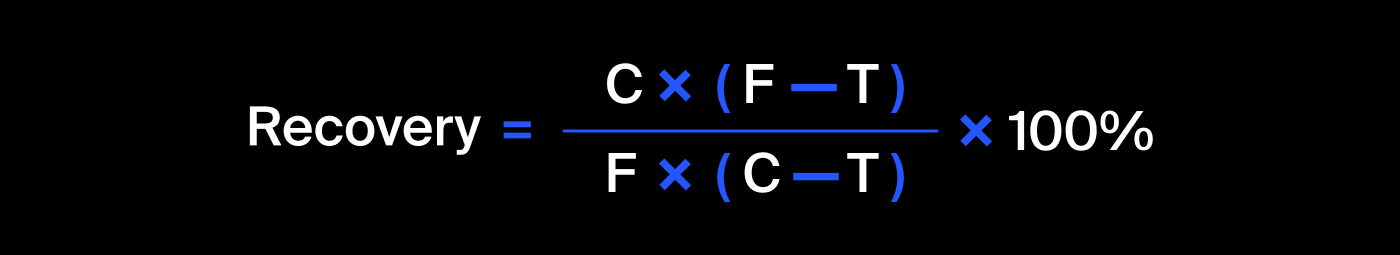

где:
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

Переведем данные определения в признаки из выборки:

- C - `rougher.output.concentrate_au`
- F - `rougher.input.feed_au`
- T - `rougher.output.tail_au`

### Расчет эффективности

In [12]:
dividend = train_data['rougher.output.concentrate_au'] * (train_data['rougher.input.feed_au'] - train_data['rougher.output.tail_au'])
divisor = train_data['rougher.input.feed_au'] * (train_data['rougher.output.concentrate_au'] - train_data['rougher.output.tail_au'])

train_data['calc_recovery'] = (dividend / divisor) * 100

### Нахождение MAE

Вычислим метрику MAE, которая покажется какая разница между нашими расчётами и значением признака и опишем выводы

In [13]:
mae = mean_absolute_error(train_data['calc_recovery'], train_data['rougher.output.recovery'])
print(f'MAE {mae}')

MAE 9.73512347450521e-15


Как мы видим, абсолютное отклонение крайне мало и мы можем подтвердить, что расчет произведен правильно

## Анализ признаков на тестовой выборке

Проанализируем признаки, которые недоступны нам на тестовой выборке. Недоступность заключается в том, что кекоторые параметры замеряются и/или рассчитываются значительно позже. Это ведет к тому, что те параметры, которые есть в обучающей выборке, но нет в тестовой мы **не можем** использовать для обучения и должны их исключить при разработке модели

In [14]:
diff_columns = list(set(train_data.columns) - set(test_data.columns))
train_data[diff_columns]

,primary_cleaner.output.tail_pb,calc_recovery,final.output.tail_sol,rougher.output.tail_au,rougher.output.recovery,rougher.output.tail_pb,rougher.output.concentrate_au,final.output.tail_ag,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.output.tail_sol,primary_cleaner.output.concentrate_ag,final.output.tail_au,final.output.concentrate_pb,rougher.output.tail_ag,primary_cleaner.output.tail_ag,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_au,final.output.concentrate_sol,final.output.recovery,rougher.calculation.au_pb_ratio,secondary_cleaner.output.tail_sol,final.output.concentrate_ag,primary_cleaner.output.tail_sol,rougher.output.concentrate_sol,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_au,secondary_cleaner.output.tail_ag,rougher.output.concentrate_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_au,rougher.calculation.floatbank10_sulfate_to_au_feed,final.output.tail_pb
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,2.534912,87.107763,16.904297,1.170244,87.107763,0.508728,19.793808,10.411962,41885.707031,3520.337158,19.154297,8.547551,2.143149,9.889648,5.008018,14.936526,34.174427,19.529297,2.106679,5.507324,70.541216,2.838687,8.764648,6.055403,7.476074,28.029297,7.101074,10.389648,42.192020,14.500184,11.500771,4.694824,2.606185,3481.779053,0.895447
2016-01-15 01:00:00,3.049646,86.843261,16.634514,1.184827,86.843261,0.536689,20.050975,10.462676,42050.861809,3489.981857,18.965234,8.558743,2.224930,9.968944,4.955378,16.250511,34.118526,19.369147,2.353017,5.257781,69.266198,2.858998,9.001494,6.029369,6.733907,28.067063,7.278807,10.497069,42.701629,14.265474,11.615865,4.592547,2.488248,3498.370979,0.927452
2016-01-15 02:00:00,3.124664,86.842308,16.208849,1.162562,86.842308,0.546416,19.737170,10.507046,42018.101184,3502.359819,18.808533,8.603505,2.257889,10.213995,4.843460,16.491823,33.969464,19.167579,2.416800,5.383759,68.116445,2.945989,8.842896,6.055926,6.471768,27.454037,7.216833,10.354494,42.657501,14.115662,11.695753,4.624775,2.458187,3495.348910,0.953716
2016-01-15 03:00:00,2.960362,87.226430,16.532835,1.079755,87.226430,0.542525,19.320810,10.422762,42029.447991,3499.162912,19.330200,7.221879,2.146849,9.977019,4.655288,16.024359,28.260743,15.978538,2.262051,4.858634,68.347543,3.002340,9.122857,6.047977,6.843791,27.341277,7.175616,8.496563,42.689819,13.732071,11.915047,4.482453,2.322062,3498.578313,0.883763
2016-01-15 04:00:00,3.112100,86.688794,16.525686,1.012642,86.688794,0.515438,19.216101,10.360302,42125.354245,3506.679315,19.267422,9.089428,2.055292,10.142511,4.552800,16.480185,33.044932,19.199864,2.277073,4.939416,66.927016,3.169615,8.871028,6.148599,6.550154,27.041023,7.240205,9.986786,42.774141,14.079996,12.411054,4.470737,2.330448,3494.800771,0.792826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-18 06:59:59,6.531541,89.574376,10.403181,0.748633,89.574376,0.612935,18.603550,8.769645,45912.942619,2499.177950,16.666590,6.559174,1.529220,11.356233,4.207261,22.854592,32.940215,7.056338,2.314352,6.803482,73.755150,1.155559,0.000000,3.224920,3.934320,30.068876,10.984003,12.445966,46.713954,0.000000,11.124896,0.000000,0.000000,2497.652954,3.141541
2018-08-18 07:59:59,6.629725,87.724007,10.549470,0.771582,87.724007,0.650557,18.441436,8.897321,46200.099585,2518.550078,16.960649,6.612376,1.612542,11.349355,4.177943,23.002490,32.925325,7.542264,2.462890,6.862249,69.049291,1.167342,0.000000,3.195978,4.089124,29.783972,10.888213,12.623947,46.866780,0.000000,11.425983,0.000000,0.000000,2614.403937,3.130493
2018-08-18 08:59:59,6.278250,88.890579,11.115147,0.685059,88.890579,0.636095,15.111231,8.529606,44585.181334,2510.142433,18.323080,7.128896,1.596616,11.434366,4.050010,22.298149,31.856742,7.941900,2.612231,6.886013,67.002189,1.125637,

In [15]:
diff_columns_df = get_feature_df(train_data, diff_columns)
diff_columns_df

Признак calc_recovery не может быть разложен на раздельные блоки


,column,stage,param_type,param_name,count_values,missing
0,primary_cleaner.output.tail_pb,primary_cleaner,output,tail_pb,14134,15
1,final.output.tail_sol,final,output,tail_sol,14144,5
2,rougher.output.tail_au,rougher,output,tail_au,14149,0
3,rougher.output.recovery,rougher,output,recovery,14149,0
4,rougher.output.tail_pb,rougher,output,tail_pb,14149,0
5,rougher.output.concentrate_au,rougher,output,concentrate_au,14149,0
6,final.output.tail_ag,final,output,tail_ag,14149,0
7,rougher.calculation.sulfate_to_au_concentrate,rougher,calculation,sulfate_to_au_concentrate,14148,1
8,rougher.calculation.floatbank11_sulfate_to_au_...,rougher,calculation,floatbank11_sulfate_to_au_feed,14148,1
9,rougher.output.tail_sol,rougher,output,tail_sol,14149,0


По результатам сравнения можно сделать вывод, что большинства параметров относятся к типу параметра - `output`, что характеризует параметры продукта после флотации/очистки.

Далее, если мы взглянем на название параметров, то станет понятно, что на тестовой выборке мы не знаем о том, какие будут **параметры продукта** и какие будут **отвальные хвосты**.

Что же касается распределение по этапам разработки, то на графике ниже видно, что большинство различий на этапе `rougher`, но нельзя сказать, что он занимает подавляющую долю - другие этапы также представлены в большом количестве.

<AxesSubplot:ylabel='stage'>

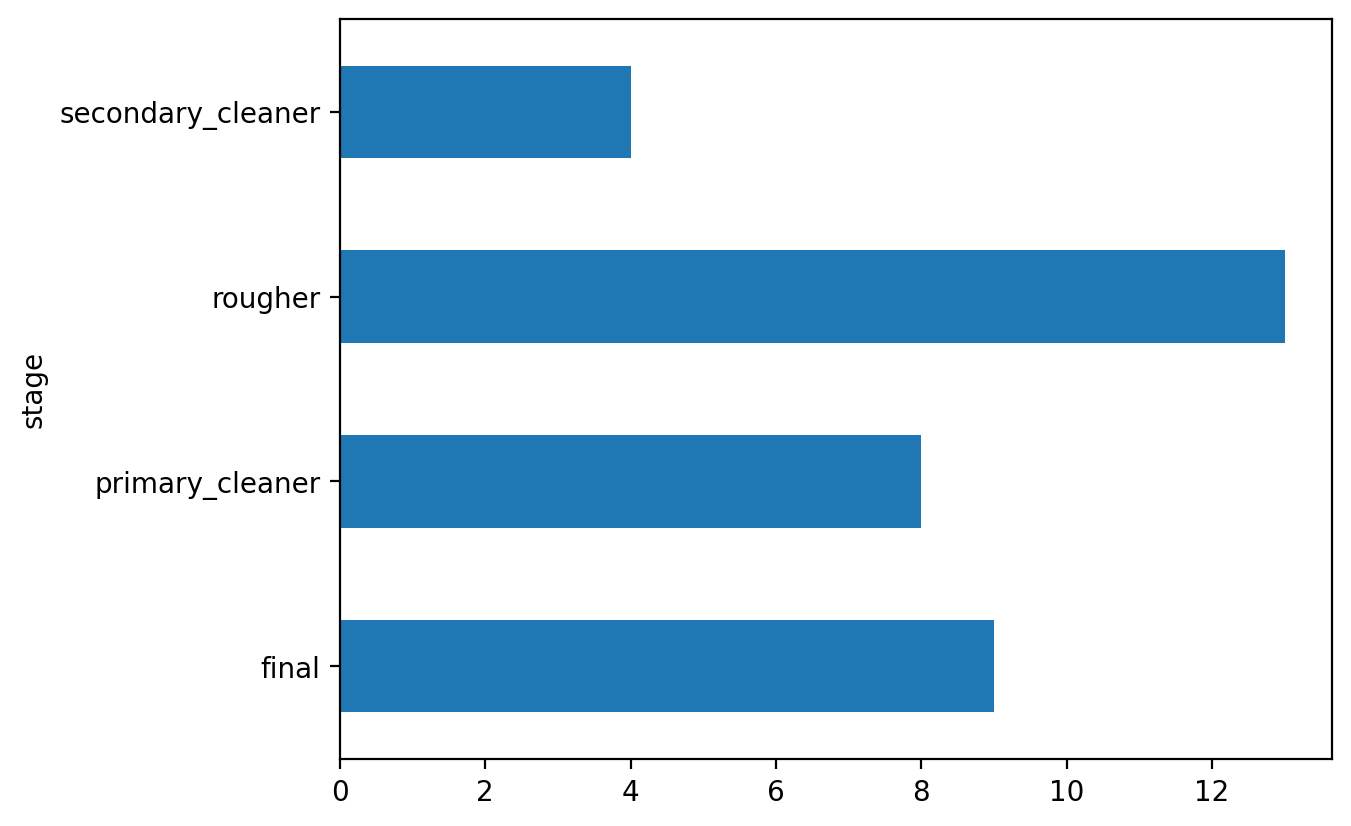

In [16]:
diff_columns_df.groupby(['stage'])['stage'].count().plot(kind='barh')

Также не стоит забывать, что на тестовой выборке нет целевых признаков `rougher.output.recovery` и `final.output.recovery`. Чтобы добавить их в датасет, возьмем эти признаки из исходных данных

In [17]:
test_data = test_data.merge(raw_data[['rougher.output.recovery', 'final.output.recovery']], left_index=True, right_index=True)

## Предобработка данных

Как мы выше отмечали, в данных, почти в каждом признаке присутствуют пропущенные значения. Чтобы устранить пропуски, мы воспользуемся методом fillna со значением аргумента method = ffill, т.к. соседние по времени параметры часто похожи, а ffill, как раз таки, позволит заполнить пустое значение предыдущим

In [18]:
train_data = train_data.fillna(method='ffill')

In [19]:
train_data.isna().sum().sum()

0

In [20]:
test_data = test_data.fillna(method='ffill')

In [21]:
test_data.isna().sum().sum()

0

По итогам прозведенных действием получаем данные без пропусков

# Анализ данных

## Анализ изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки.

Проанализируем как на разных этапах обработки меняется концентрация выбранных металлов. Сначала определим, какие атрибуты будут характеризовать концентрацию:

**Au:**

- rougher.input.feed_au
- rougher.output.concentrate_au
- primary_cleaner.output.concentrate_au
- final.output.concentrate_au

**Ag:**

- rougher.input.feed_ag
- rougher.output.concentrate_ag
- primary_cleaner.output.concentrate_ag
- final.output.concentrate_ag

**Pb:**

- rougher.input.feed_pb
- rougher.output.concentrate_pb
- primary_cleaner.output.concentrate_pb
- final.output.concentrate_pb

Напишем функцию для визуализации измненений:

In [22]:
def concentrate_change_plot(metal_type: str, color: str):
    
    metal_type = str.lower(metal_type)
    
    rougher_input = 'rougher.input.feed_' + metal_type
    rougher_output = 'rougher.output.concentrate_' + metal_type
    primary_output = 'primary_cleaner.output.concentrate_' + metal_type
    final_output = 'final.output.concentrate_' + metal_type
    
    grouped_data = raw_data[[rougher_input, rougher_output, primary_output, final_output]].agg(['mean']).T.reset_index()
    
    
    plt.figure(figsize=(16,6))
    sns.set_style('whitegrid')
    ax = sns.barplot(data=grouped_data, x='index', y='mean', color=color)
    ax.set_xticklabels(['Исходная смесь','Черновой концентрат', 'Первый этап очистики', 'Финальный концентрат'])
    plt.title(f'Изменение концетрации {metal_type} по этапам обработки')
    plt.ylabel(f'Доля {metal_type} в концетрате')
    plt.xlabel('Этап обработки')
    plt.show()

### Золото

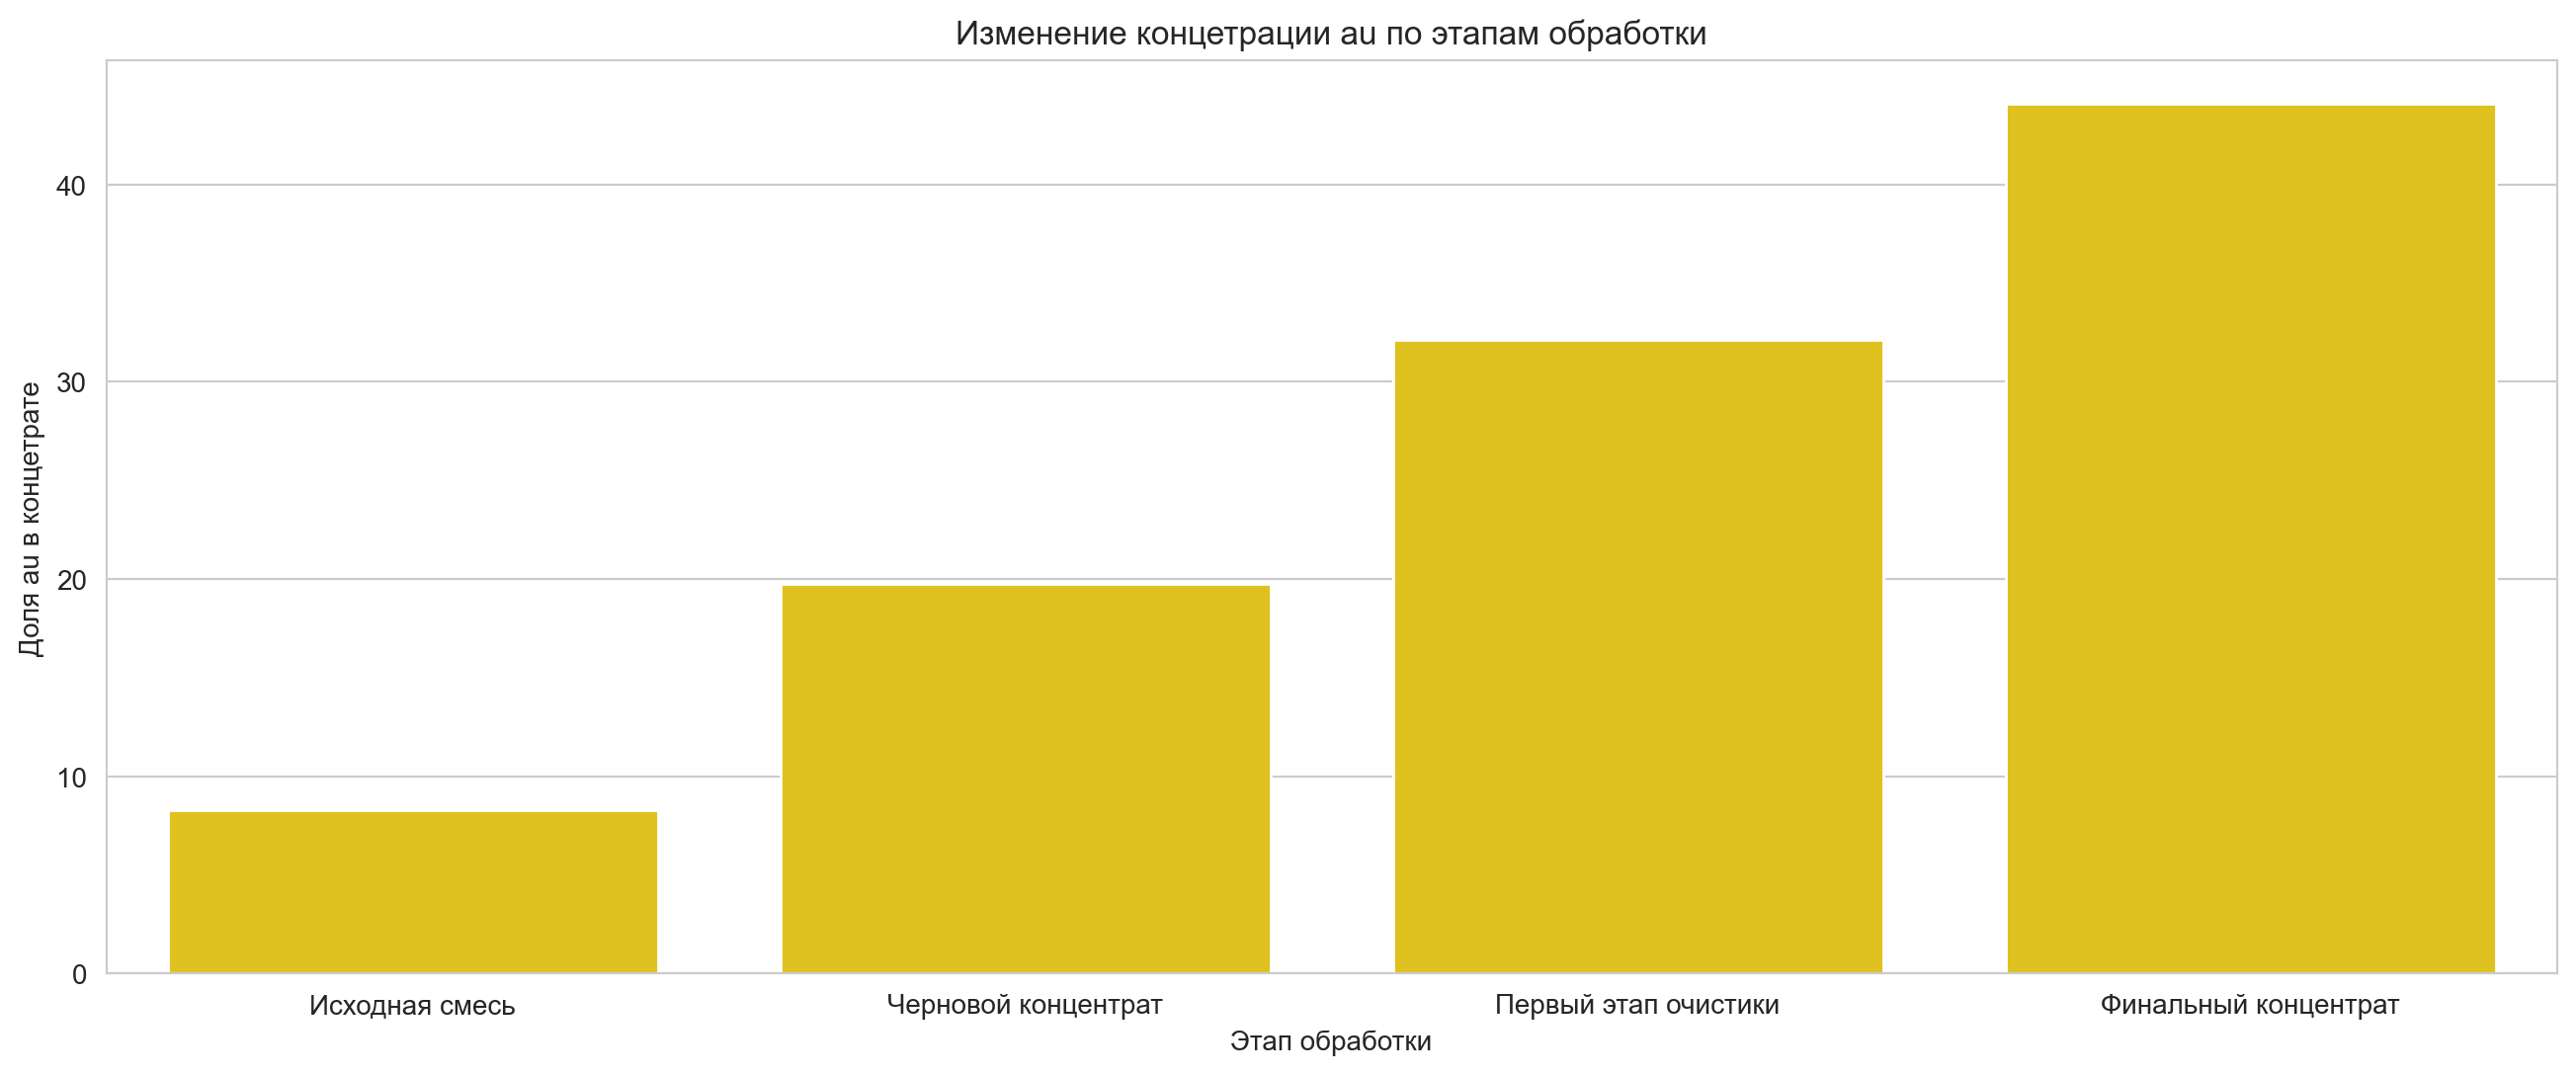

In [23]:
concentrate_change_plot('au', 'gold')

Как видно на графике, доля золота стабильно растет из этапа в этап. После этапа флотации доля золота увеличается в 2 раза, а на последюущих двух этапах увеличение примерно в 1.5 раза

### Серебро

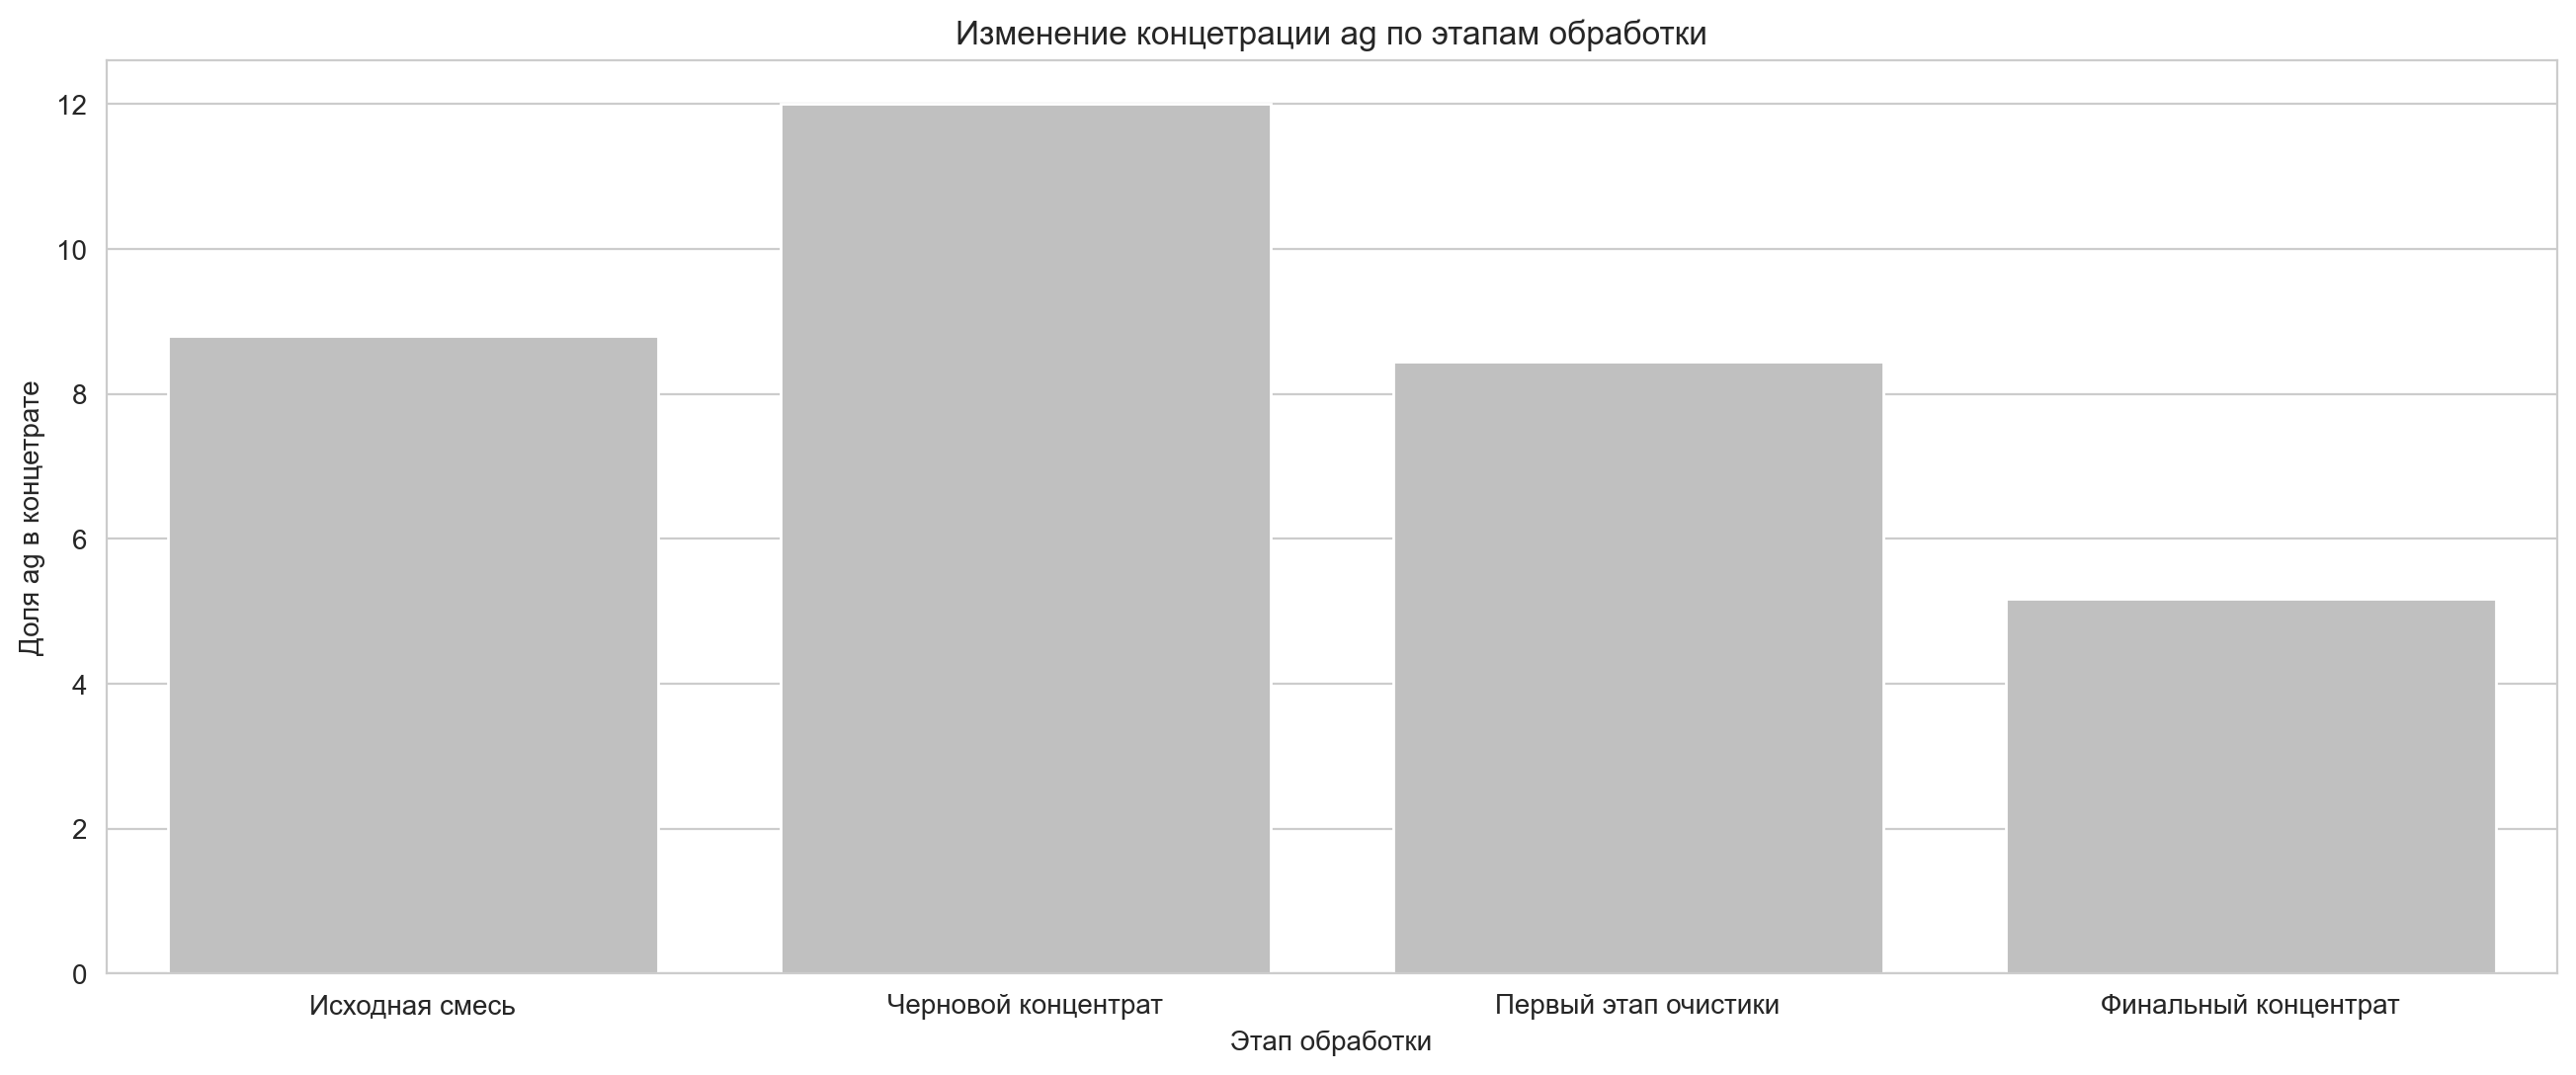

In [24]:
concentrate_change_plot('ag', 'silver')

С серебром наблюдается обратная ситуация - не смотря на то, что после этапа флотации доля серебра выросла, в конечном счете, в финальном концентрате доля металла существенно снизилась по сравнению с исходной смесью

### Свинец

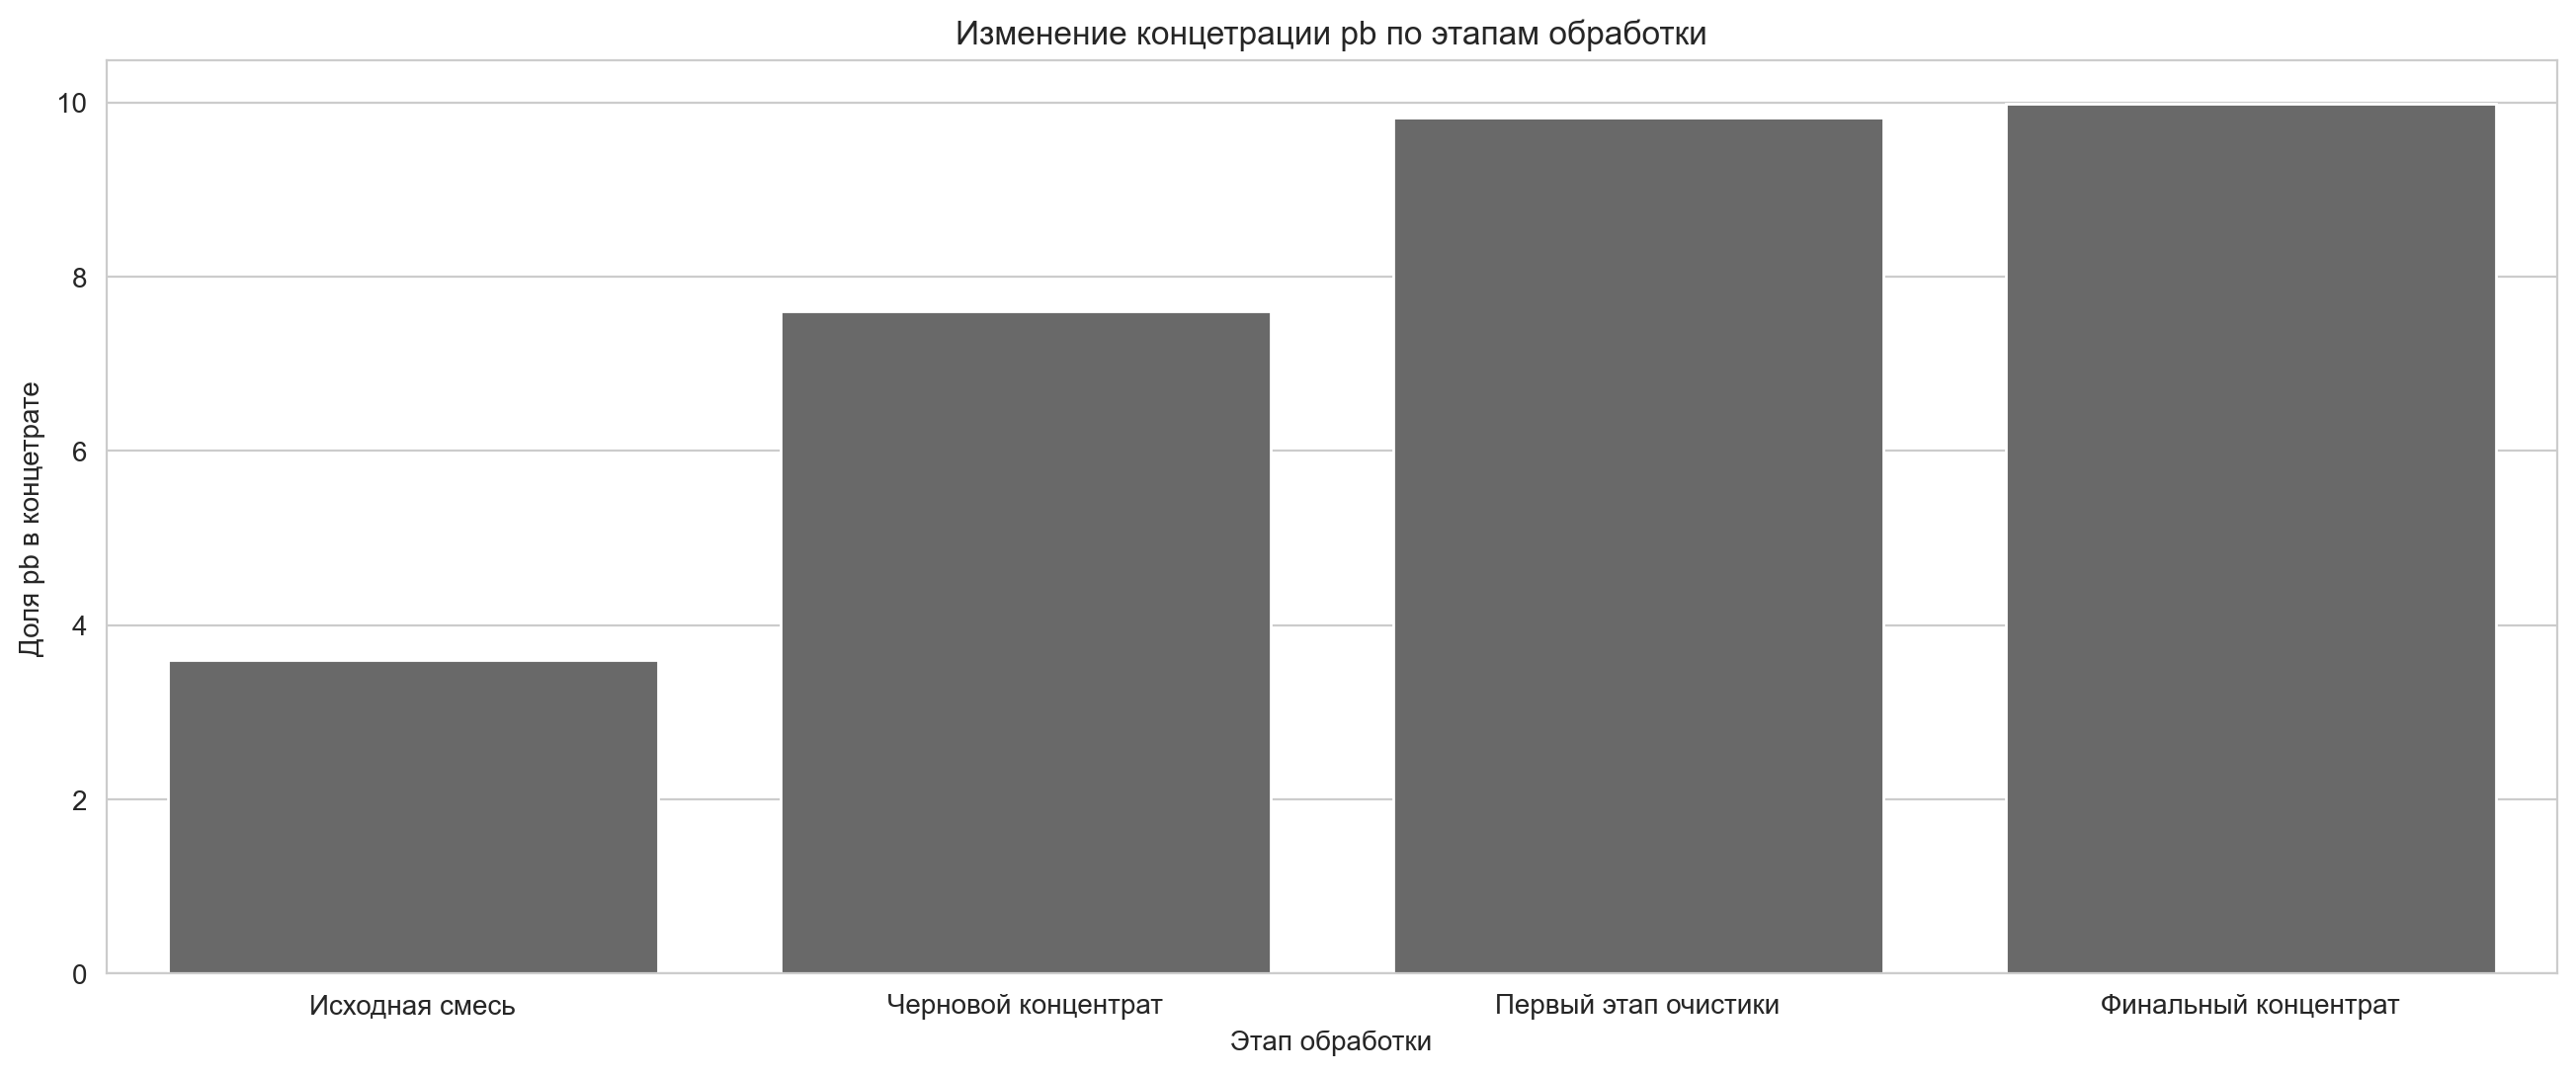

In [25]:
concentrate_change_plot('pb', 'dimgrey')

Измненения при обработке свинца схожи с золотом - после этапа флотации наблюдается существенное увеличение доли металла. После проведения первого и второго этапа очистки доля свинца также немного подросла

## Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

Необходимо сравнить, как различаются размеры гранул сырья на трейне и на тесте. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной

Чтобы качественно сравнить распределение выполним следующие шаги:
1. Отберем признаки `primary_cleaner.input.feed_size` и `rougher.input.feed_size`, в которых и содержится информация о размере гранул
2. Построим график распределения гранул
3. Проведем статистический тест и проверем гипотезу о равенстве выборок

In [95]:
def compare_feed_size(feature: str):
    
    plt.figure(figsize=(16,6))
    sns.set_style('whitegrid')
    
    sns.kdeplot(data=train_data, x=feature, linewidth=3, fill=True)
    sns.kdeplot(data=test_data, x=feature, linewidth=3, fill=True)
    
    plt.title('Распределение размеров гранул сырья на обучающей и тестовой выборках')
    plt.legend(labels=['Обучающаяся выборка', 'Тестовая выборка'])
    plt.ylabel('Плотность')
    plt.xlabel('Размер гранул')
    plt.show()

### Размер гранул в исходной смеси

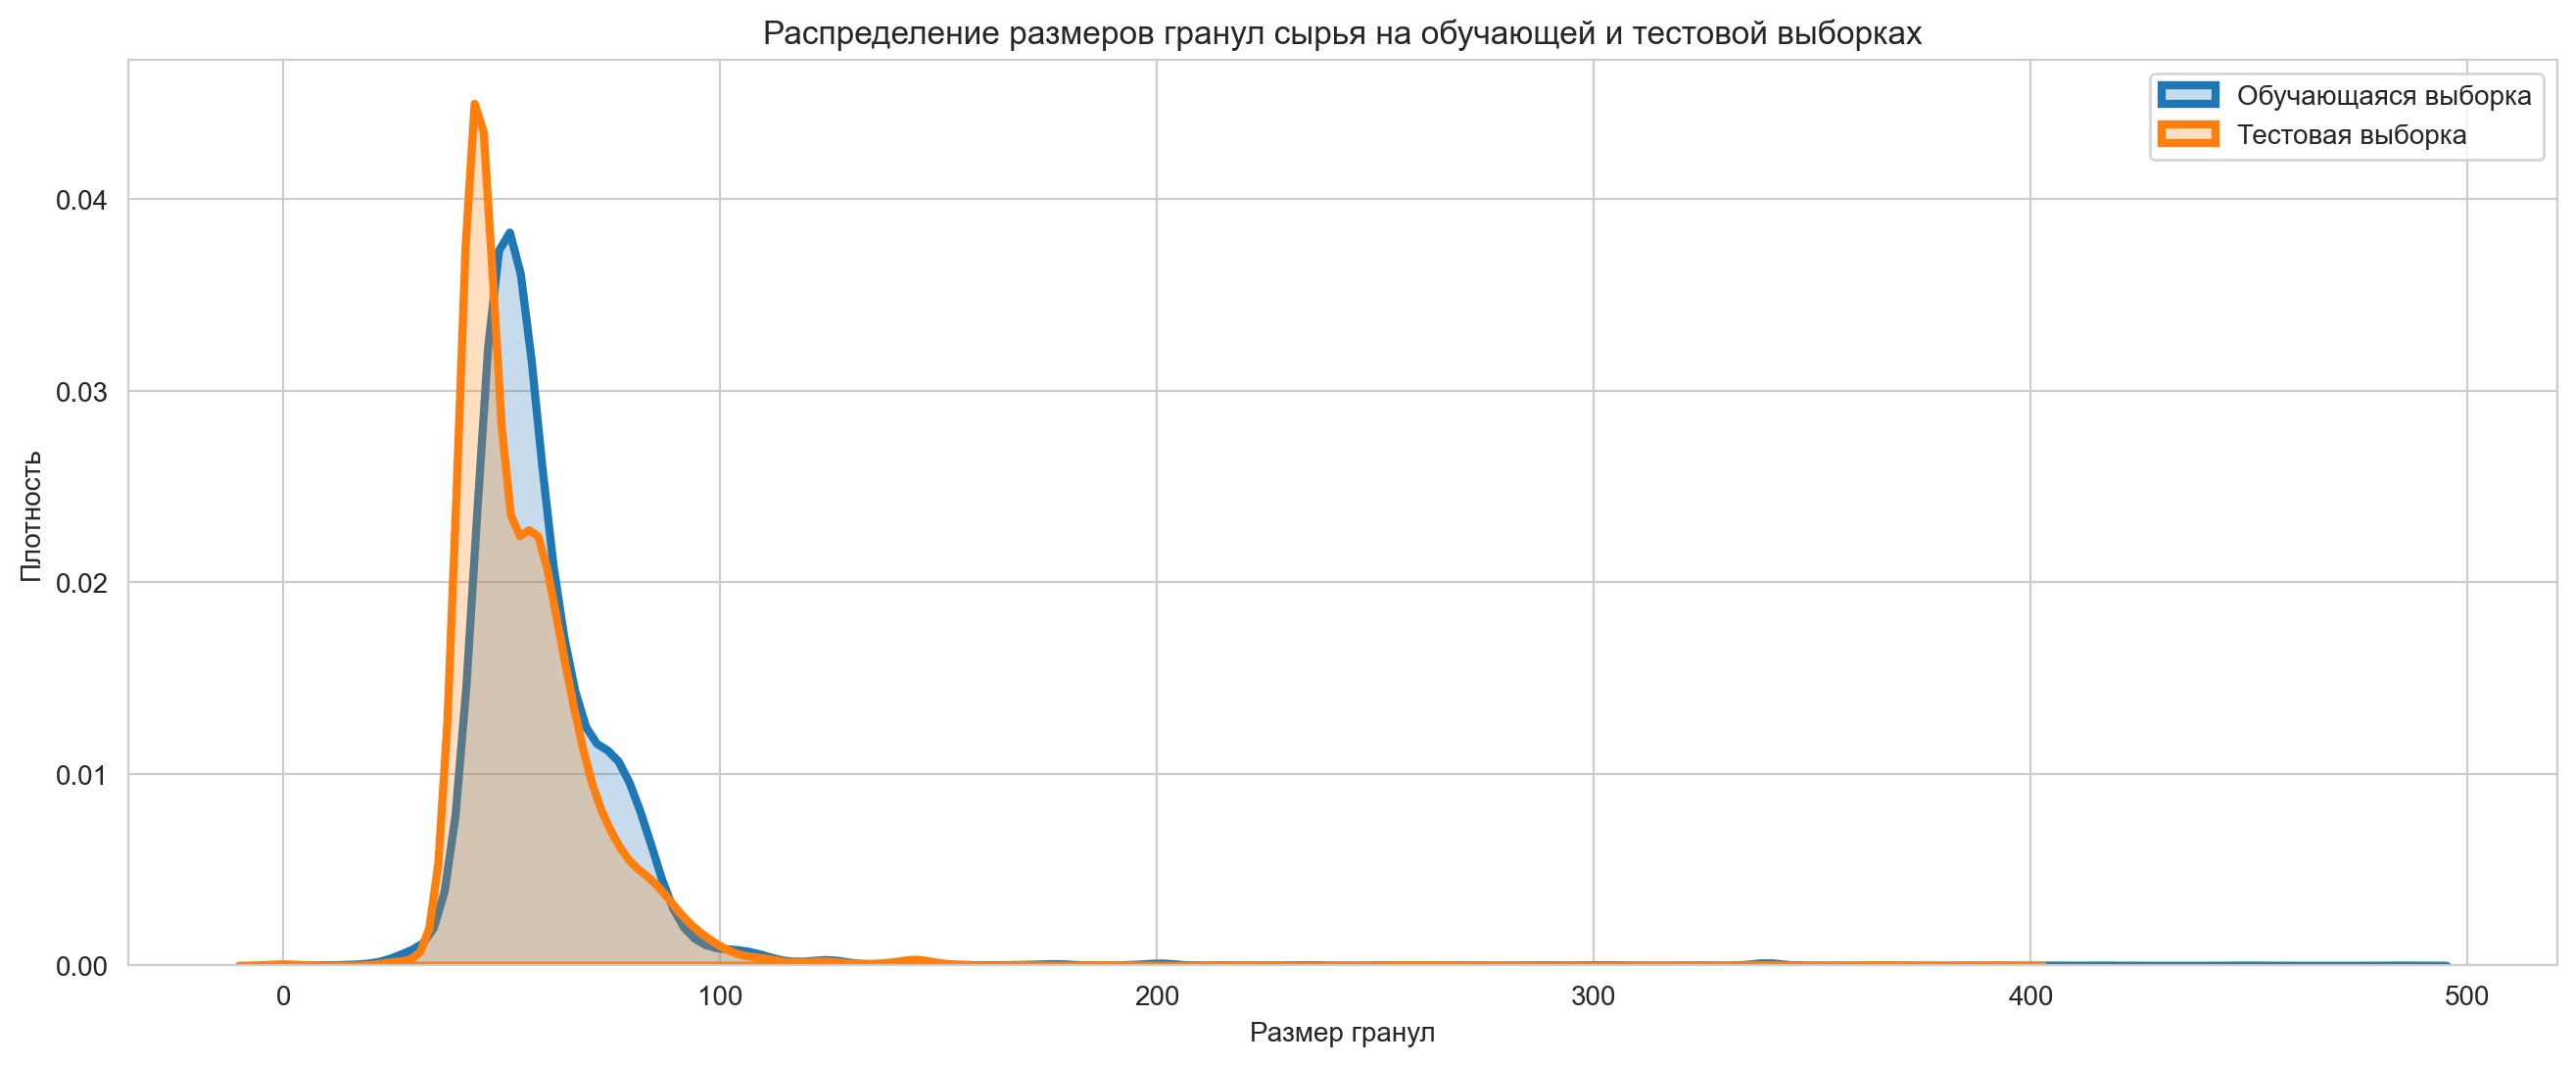

In [96]:
compare_feed_size('rougher.input.feed_size')

Распределение гранул в исходной смеси можно назвать одинаковым. Среднее значение тестовой выборки слегка смещено, но силуэты распредлений примерно равны.

### Размер гранул после флотации

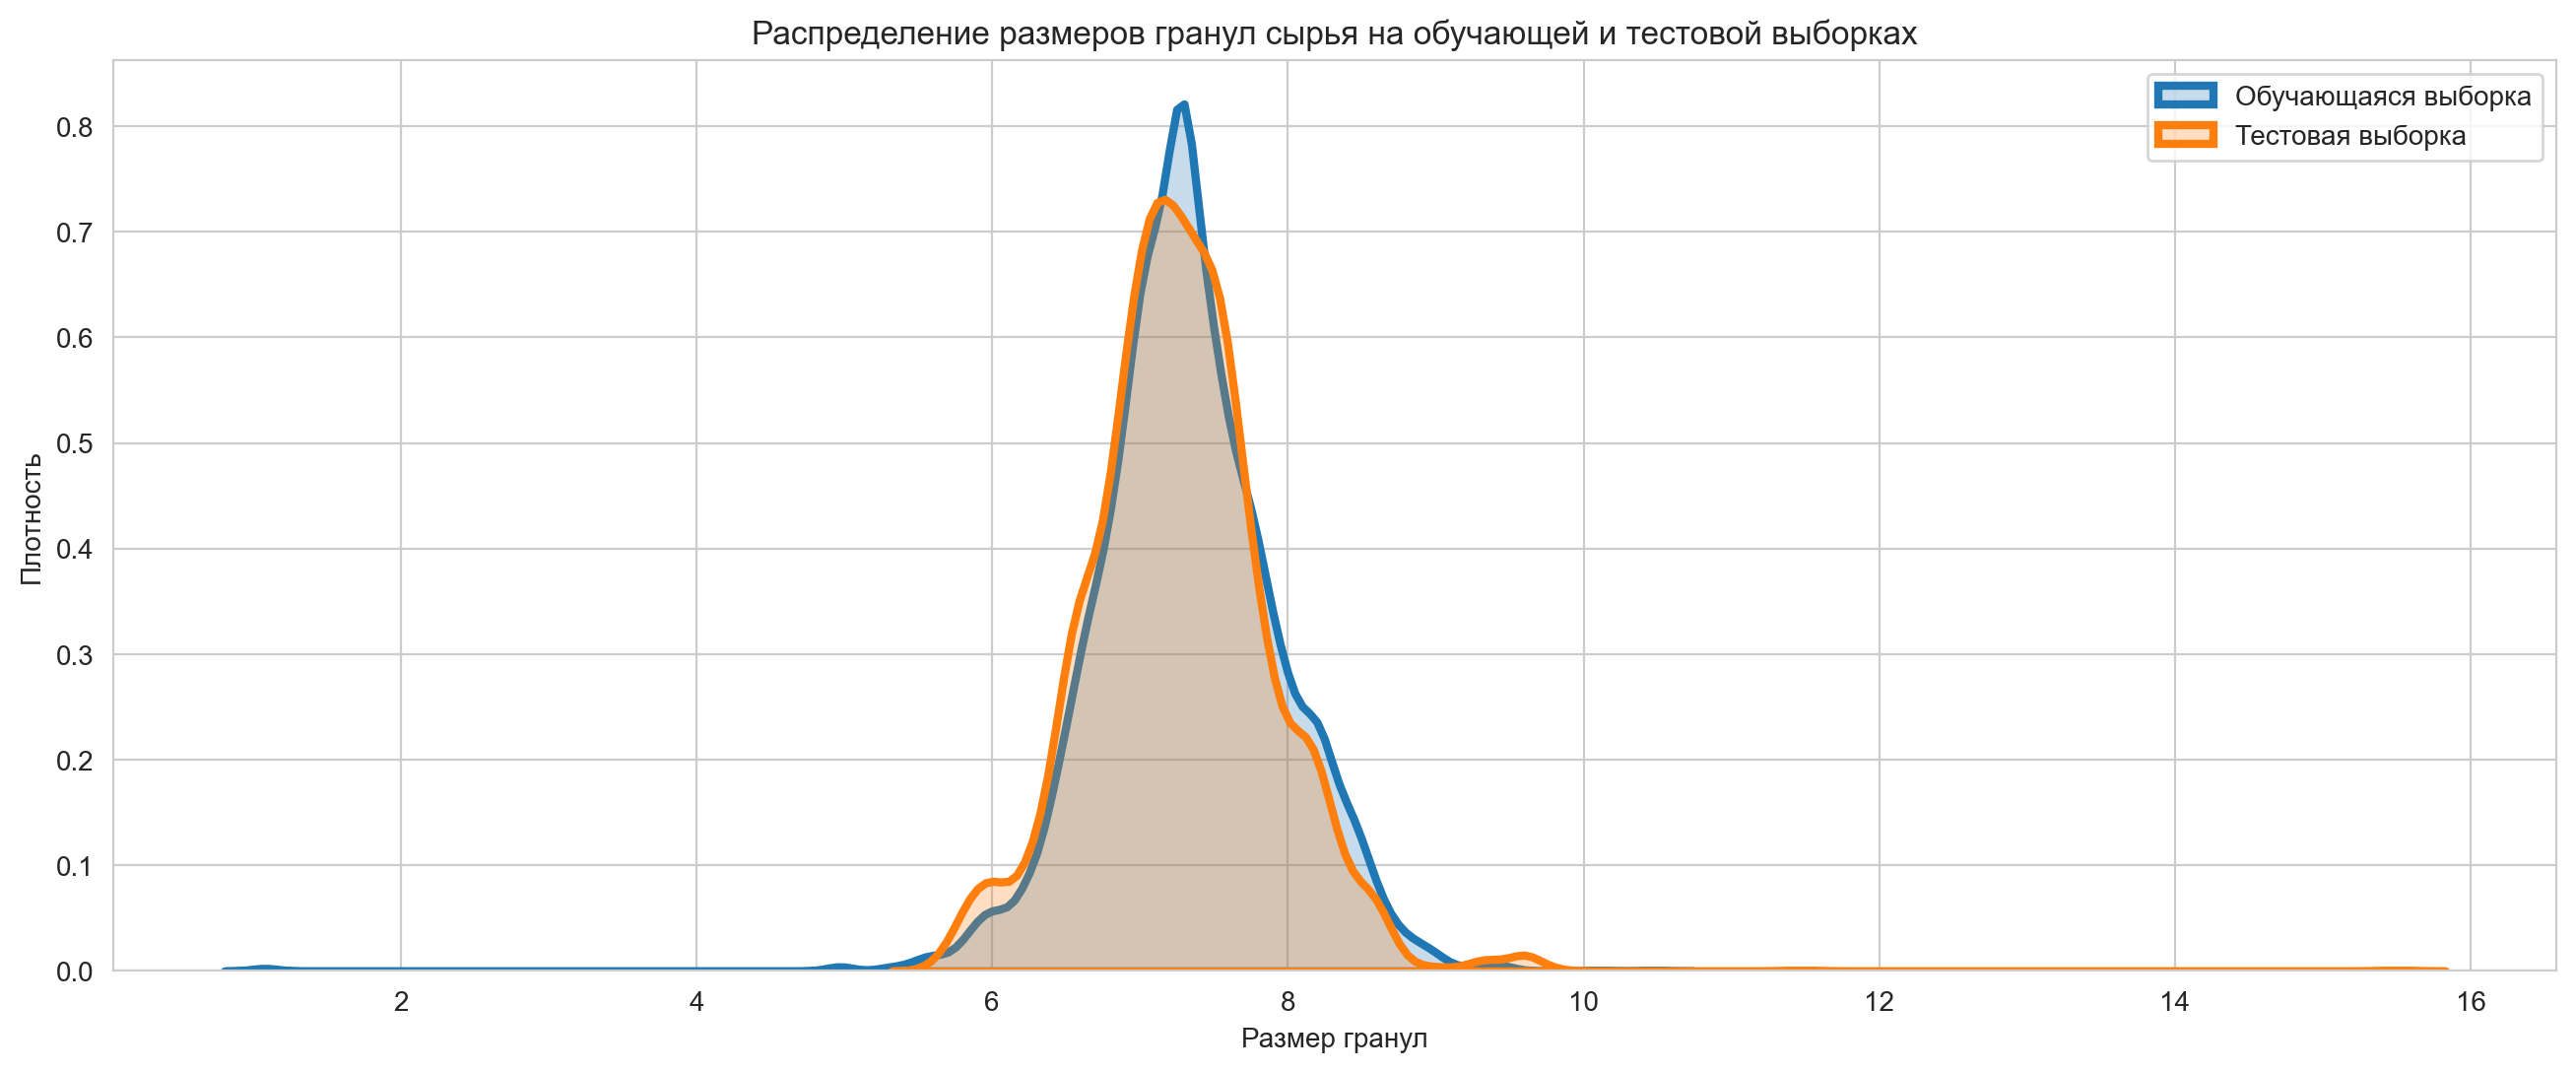

In [97]:
compare_feed_size('primary_cleaner.input.feed_size')

После флотации распределение еще более одинаково, за исключением небольшого пика обучающейся выборки

## Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

Для этого исследования выполним следюущие действия:
1. возьмем признаки из пункта 3.1 и добавим к ним `sol` (зола)
2. просуммируем разные вещества по стадиям обработки

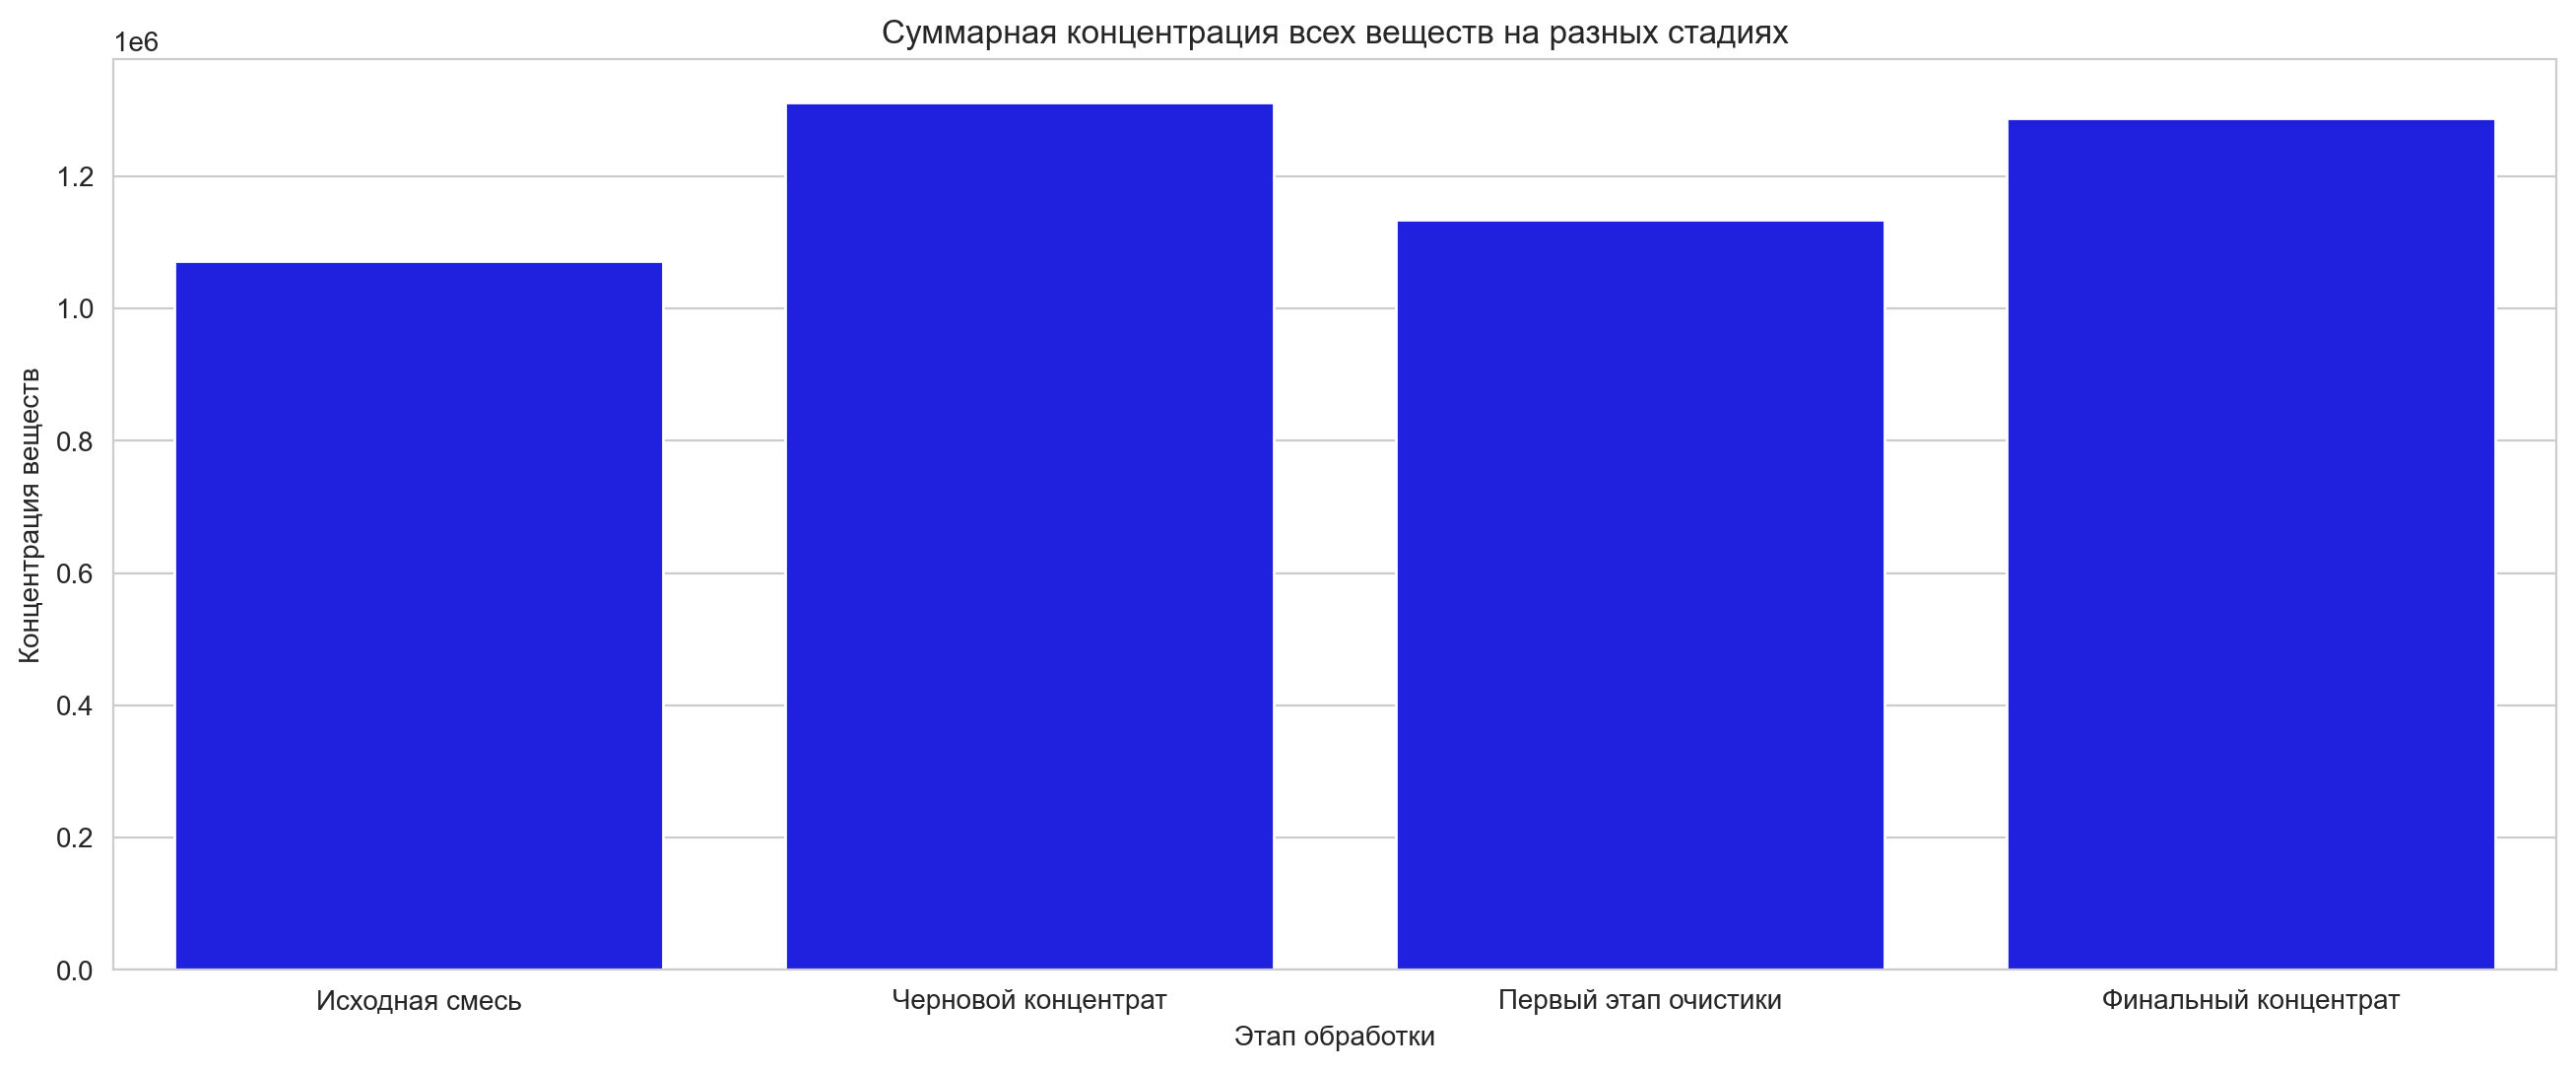

In [29]:
raw_data['rougher.input.total'] = raw_data['rougher.input.feed_au'] + raw_data['rougher.input.feed_ag'] + raw_data['rougher.input.feed_pb'] + raw_data['rougher.input.feed_sol']
raw_data['rougher.output.total'] = raw_data['rougher.output.concentrate_au'] + raw_data['rougher.output.concentrate_ag'] + raw_data['rougher.output.concentrate_pb'] + raw_data['rougher.output.concentrate_sol']
raw_data['primary_cleaner.output.total'] = raw_data['primary_cleaner.output.concentrate_au'] + raw_data['primary_cleaner.output.concentrate_ag'] + raw_data['primary_cleaner.output.concentrate_pb'] + raw_data['primary_cleaner.output.concentrate_sol']
raw_data['final.output.total'] = raw_data['final.output.concentrate_au'] + raw_data['final.output.concentrate_ag'] + raw_data['final.output.concentrate_pb'] + raw_data['final.output.concentrate_sol']

grouped_data = raw_data[(raw_data['final.output.total'] != 0) & (raw_data['primary_cleaner.output.total'] != 0) & (raw_data['rougher.output.total'] != 0) & (raw_data['rougher.input.total'] != 0)][['rougher.input.total', 'rougher.output.total', 'primary_cleaner.output.total', 'final.output.total']].agg(['sum']).T.reset_index()

plt.figure(figsize=(16,6))
sns.set_style('whitegrid')

ax = sns.barplot(data=grouped_data, x='index', y='sum', color='blue')
ax.set_xticklabels(['Исходная смесь','Черновой концентрат', 'Первый этап очистики', 'Финальный концентрат'])

plt.title('Суммарная концентрация всех веществ на разных стадиях')
plt.ylabel('Концентрация веществ')
plt.xlabel('Этап обработки')
plt.show()

Судя по графику, нельзя сказать, что суммарная концетрация растет из этапа в этап - после первого этапа очистики наблюдается спад суммарной концетрации и рост на финальном концентрате.

# Построение модели

## Функция для вычисления итоговой метрики sMAPE

Напишем функцию для вычисления метрики sMAPE — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных и одинаково учитывает масштаб и целевого признака, и предсказания.

Метрика sMAPE вычисляется так:

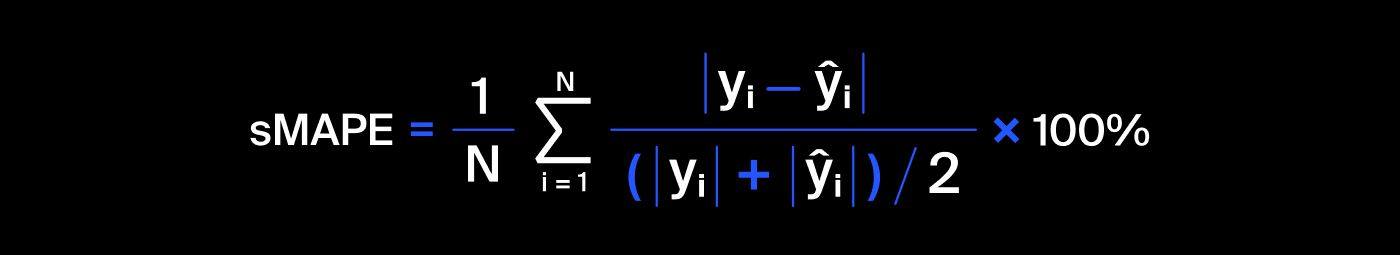

In [30]:
def make_smape_score(y_true, y_pred):
    #score = 1/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))*100)
    score =  np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))*100
    
    return score

In [31]:
smape_score = make_scorer(make_smape_score, greater_is_better=False)

Для вычисления финальной метрики воспользуемся следующей формулой:

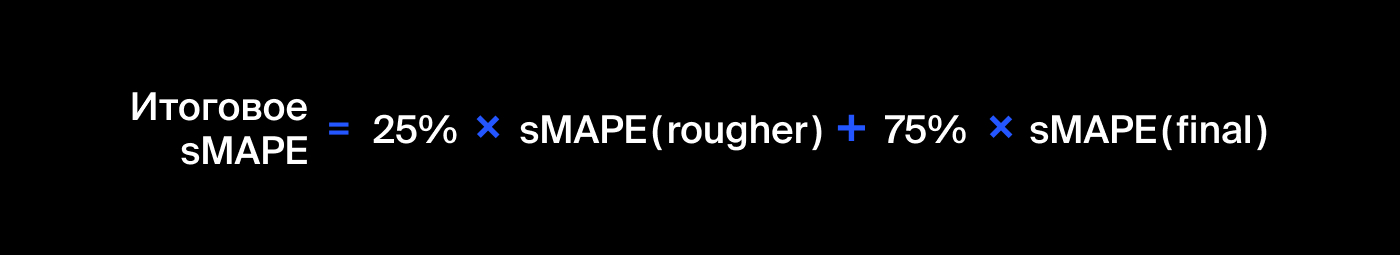

In [32]:
def final_smape_score(smape_rougher_score, smape_final_score):
    final_smape = (0.25 * smape_rougher_score) + (0.75 * smape_final_score)
    return final_smape

## Подготовка данных

Подготовим данные для обучения моделей. Для этого:

- приведем в соответствие кол-во признаков на трейне и на тесте (помним, что некоторые признаким могут отсутствовать на тесте)
- разделим данные для обучения
- выполним масштабирование признаков

In [33]:
# выбираем признаки в трейне, которые есть на тесте
X_train = train_data[test_data.columns]

In [34]:
# Разделяем данные на признаки и таргет
X_train = X_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
y0_train = train_data['rougher.output.recovery']
y1_train = train_data['final.output.recovery']

X_test = test_data.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
y0_test = test_data['rougher.output.recovery']
y1_test = test_data['final.output.recovery']

In [35]:
# Масштабирование признаков
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

minmax = MinMaxScaler()

X_train_scaled = minmax.fit_transform(X_train_scaled)
X_test_scaled = minmax.transform(X_test_scaled)

In [36]:
X_train.shape, X_test.shape

((14149, 52), (5290, 52))

## Обучение базовых моделей и оценка их качества кросс-валидацией

Обучим 4 модели без параметров и посмотрим на метрики

### Linear Regression

In [37]:
linreg = LinearRegression()

In [38]:
rougher_scores = cross_val_score(linreg, X_train_scaled, y0_train, cv=5, scoring=smape_score, n_jobs=-1)
smape_rougher_score = sum(rougher_scores)/len(rougher_scores)
print(f'sMAPE эффективности обогащения чернового концентрата {smape_rougher_score}')

sMAPE эффективности обогащения чернового концентрата -12.802483458481953


In [39]:
final_scores = cross_val_score(linreg, X_train_scaled, y1_train, cv=5, scoring=smape_score, n_jobs=-1)
smape_final_score = sum(final_scores)/len(final_scores)
print(f'sMAPE эффективности обогащения финального концентрата {smape_final_score}')

sMAPE эффективности обогащения финального концентрата -12.245300320302228


In [40]:
final_smape = final_smape_score(smape_rougher_score, smape_final_score)
print(f'Итоговое sMAPE {final_smape}')

Итоговое sMAPE -12.384596104847159


### Decision Tree Regressor

In [41]:
tree = DecisionTreeRegressor()

In [42]:
rougher_scores = cross_val_score(tree, X_train_scaled, y0_train, cv=5, scoring=smape_score, n_jobs=-1)
smape_rougher_score = sum(rougher_scores)/len(rougher_scores)
print(f'sMAPE эффективности обогащения чернового концентрата {smape_rougher_score}')

sMAPE эффективности обогащения чернового концентрата -18.896998069737837


In [43]:
final_scores = cross_val_score(tree, X_train_scaled, y1_train, cv=5, scoring=smape_score, n_jobs=-1)
smape_final_score = sum(final_scores)/len(final_scores)
print(f'sMAPE эффективности обогащения финального концентрата {smape_final_score}')

sMAPE эффективности обогащения финального концентрата -23.456469077260117


In [44]:
final_smape = final_smape_score(smape_rougher_score, smape_final_score)
print(f'Итоговое sMAPE {final_smape}')

Итоговое sMAPE -22.316601325379544


### Random Forest Regressor

In [45]:
forest = RandomForestRegressor()

In [46]:
rougher_scores = cross_val_score(forest, X_train_scaled, y0_train, cv=5, scoring=smape_score, n_jobs=-1)
smape_rougher_score = sum(rougher_scores)/len(rougher_scores)
print(f'sMAPE эффективности обогащения чернового концентрата {smape_rougher_score}')

sMAPE эффективности обогащения чернового концентрата -13.429899737929725


In [47]:
final_scores = cross_val_score(forest, X_train_scaled, y1_train, cv=5, scoring=smape_score, n_jobs=-1)
smape_final_score = sum(final_scores)/len(final_scores)
print(f'sMAPE эффективности обогащения финального концентрата {smape_final_score}')

sMAPE эффективности обогащения финального концентрата -11.367073520822792


In [48]:
final_smape = final_smape_score(smape_rougher_score, smape_final_score)
print(f'Итоговое sMAPE {final_smape}')

Итоговое sMAPE -11.882780075099525


### CatBoost Regressor

In [49]:
catboost = CatBoostRegressor(logging_level='Verbose')

In [50]:
rougher_scores = cross_val_score(catboost, X_train_scaled, y0_train, cv=5, scoring=smape_score, n_jobs=-1)
smape_rougher_score = sum(rougher_scores)/len(rougher_scores)
print(f'sMAPE эффективности обогащения чернового концентрата {smape_rougher_score}')

Learning rate set to 0.060073
0:	learn: 15.1184330	total: 73.3ms	remaining: 1m 13s
1:	learn: 14.8686847	total: 81.9ms	remaining: 40.9s
2:	learn: 14.6193126	total: 89.5ms	remaining: 29.8s
3:	learn: 14.4164792	total: 98ms	remaining: 24.4s
4:	learn: 14.2011051	total: 107ms	remaining: 21.3s
5:	learn: 14.0234955	total: 115ms	remaining: 19s
6:	learn: 13.8532882	total: 124ms	remaining: 17.5s
7:	learn: 13.6815353	total: 131ms	remaining: 16.2s
8:	learn: 13.5236800	total: 142ms	remaining: 15.6s
9:	learn: 13.3618161	total: 149ms	remaining: 14.8s
10:	learn: 13.2343072	total: 157ms	remaining: 14.1s
11:	learn: 13.0930409	total: 166ms	remaining: 13.6s
12:	learn: 12.9853622	total: 173ms	remaining: 13.2s
13:	learn: 12.8656585	total: 182ms	remaining: 12.8s
14:	learn: 12.7344806	total: 188ms	remaining: 12.3s
15:	learn: 12.6496178	total: 194ms	remaining: 11.9s
16:	learn: 12.5628790	total: 201ms	remaining: 11.6s
17:	learn: 12.4678195	total: 209ms	remaining: 11.4s
18:	learn: 12.3913934	total: 215ms	remainin

In [51]:
final_scores = cross_val_score(catboost, X_train_scaled, y1_train, cv=5, scoring=smape_score, n_jobs=-1)
smape_final_score = sum(final_scores)/len(final_scores)
print(f'sMAPE эффективности обогащения финального концентрата {smape_final_score}')

632:	learn: 4.6323446	total: 4.73s	remaining: 2.74s
633:	learn: 4.6306100	total: 4.74s	remaining: 2.73s
634:	learn: 4.6262122	total: 4.75s	remaining: 2.73s
635:	learn: 4.6246664	total: 4.75s	remaining: 2.72s
636:	learn: 4.6210131	total: 4.76s	remaining: 2.71s
637:	learn: 4.6176391	total: 4.77s	remaining: 2.71s
638:	learn: 4.6110190	total: 4.78s	remaining: 2.7s
639:	learn: 4.6083416	total: 4.78s	remaining: 2.69s
640:	learn: 4.6051285	total: 4.79s	remaining: 2.68s
641:	learn: 4.5995351	total: 4.8s	remaining: 2.68s
642:	learn: 4.5951231	total: 4.81s	remaining: 2.67s
643:	learn: 4.5905536	total: 4.81s	remaining: 2.66s
644:	learn: 4.5879632	total: 4.82s	remaining: 2.65s
645:	learn: 4.5851224	total: 4.83s	remaining: 2.65s
646:	learn: 4.5815605	total: 4.83s	remaining: 2.64s
647:	learn: 4.5771069	total: 4.84s	remaining: 2.63s
648:	learn: 4.5729393	total: 4.85s	remaining: 2.62s
649:	learn: 4.5689153	total: 4.86s	remaining: 2.62s
650:	learn: 4.5636072	total: 4.86s	remaining: 2.61s
651:	learn: 4.

In [52]:
final_smape = final_smape_score(smape_rougher_score, smape_final_score)
print(f'Итоговое sMAPE {final_smape}')

Итоговое sMAPE -11.659863164408138


## Обучение модели с гиперпараметрами

Обучим модель CatBoost Regressor (которая показала наиболее высокий скор) с подбором гиперпараметров

In [60]:
def catboost_tuning(X_train, y_train, params=None):
    
    # Для ускорения обучения (и проверки) добавлю возможность провести обучение самому и использовать подобранные на 
    # личном компьютере параметры
    
    if params != None:
        
        catboost = CatBoostRegressor(
        random_state=987,
        eval_metric='SMAPE',
        logging_level='Silent',
        custom_metric='SMAPE',
        thread_count=-1,
        **params
        )
        
        score = cross_val_score(catboost, X_train, y_train, cv=5, scoring=smape_score, n_jobs=-1)
        
        smape_score_output = score.mean()
    
        return params, smape_score_output
    
    else:
    
        # Создаем экземпляры класса Pool, в которые будут храниться наши данные

        train_pool = Pool(X_train, y_train)

        # Проинициализируем класс классификатора без гиперпараметров

        catboost = CatBoostRegressor(
        random_state=987,
        eval_metric='SMAPE',
        logging_level='Silent',
        custom_metric='SMAPE',
        thread_count=-1
        )


        # Создаем сетку гиперпараметров. Для optuna необходимо использовать
        # встроенные классы для создания распределений значения того или иного параметра

        params_distr = {
        'learning_rate': CategoricalDistribution([0.01, 0.05, 0.1, 0.5]),
        'max_depth': IntUniformDistribution(6, 12),
        'l2_leaf_reg': IntUniformDistribution(30, 60, 5),
        'random_strength': UniformDistribution(2.0, 5.0),
        'border_count': IntUniformDistribution(64, 254),
        'bagging_temperature': UniformDistribution(3.0, 5.0)
        }

        # Создаем экземпляр класса для поиска

        optuna_search = OptunaSearchCV(
        catboost,
        params_distr,
        random_state=987,
        n_trials=3,
        n_jobs=-1,
        verbose=0,
        cv=5,
        scoring=smape_score,
        refit=True
        )

        # Начинаем поиск

        optuna_search.fit(X_train, y_train)

        # Выводим лучшие параметры и сохраняем их в переменную

        best_params = optuna_search.best_params_
        print(best_params)

        # Запускаем обучение с найденным гиперпараметрами и выводим полученные метрики

        smape_score_output = optuna_search.best_score_
    
        return best_params, smape_score_output

In [61]:
params_rougher = {
    'learning_rate': 0.01, 
    'max_depth': 9, 
    'l2_leaf_reg': 38.82209290016154, 
    'random_strength': 3.5428904002493606, 
    'border_count': 74, 
    'bagging_temperature': 4.030776432987441
}

In [62]:
best_params_rougher, smape_rougher_score = catboost_tuning(X_train_scaled, y0_train, params_rougher)

In [63]:
print(f'sMAPE эффективности обогащения чернового концентрата {smape_rougher_score}')

sMAPE эффективности обогащения чернового концентрата -10.48447528351441


In [64]:
params_final = {
    'learning_rate': 0.01, 
    'max_depth': 7, 
    'l2_leaf_reg': 56.5679677619531, 
    'random_strength': 3.3131092231309456, 
    'border_count': 197, 
    'bagging_temperature': 4.192054642119149
}

In [65]:
best_params_final, smape_final_score = catboost_tuning(X_train_scaled, y1_train, params_final)

In [66]:
print(f'sMAPE эффективности обогащения финального концентрата {smape_final_score}')

sMAPE эффективности обогащения финального концентрата -9.59740154091462


In [67]:
final_smape = final_smape_score(smape_rougher_score, smape_final_score)
print(f'Итоговое sMAPE {final_smape}')

Итоговое sMAPE -9.819169976564567


Я не сильно улучшил метрику, по сравнению с бейзлайн моделью, но прибавка однозначно есть

## Проверка лучшей модели на тестовой выборке

Проверим модель с отобранными гиперпараметрами на тестовой выборке

In [68]:
def train_catboost(params):
    catboost_tuned = CatBoostRegressor(
        random_state=987,
        eval_metric='SMAPE',
        logging_level='Verbose',
        custom_metric='SMAPE',
        **params
    )
    
    return catboost_tuned

Обучаем 2 модели, гиперпараметры берем из шага 4.4

In [69]:
rougher_catboost = train_catboost(best_params_rougher)

In [70]:
rougher_catboost.fit(X_train_scaled, y0_train)

0:	learn: 11.7897351	total: 75.8ms	remaining: 1m 15s
1:	learn: 11.7632131	total: 80.8ms	remaining: 40.3s
2:	learn: 11.7376303	total: 86.6ms	remaining: 28.8s
3:	learn: 11.7129482	total: 91.2ms	remaining: 22.7s
4:	learn: 11.6883726	total: 96.1ms	remaining: 19.1s
5:	learn: 11.6652727	total: 101ms	remaining: 16.7s
6:	learn: 11.6444695	total: 105ms	remaining: 14.9s
7:	learn: 11.6206824	total: 109ms	remaining: 13.6s
8:	learn: 11.5989219	total: 114ms	remaining: 12.5s
9:	learn: 11.5720738	total: 118ms	remaining: 11.7s
10:	learn: 11.5463417	total: 122ms	remaining: 11s
11:	learn: 11.5185960	total: 128ms	remaining: 10.5s
12:	learn: 11.4989909	total: 132ms	remaining: 10s
13:	learn: 11.4745305	total: 137ms	remaining: 9.62s
14:	learn: 11.4540725	total: 141ms	remaining: 9.27s
15:	learn: 11.4314619	total: 146ms	remaining: 8.98s
16:	learn: 11.4109734	total: 151ms	remaining: 8.72s
17:	learn: 11.3872016	total: 156ms	remaining: 8.51s
18:	learn: 11.3663538	total: 161ms	remaining: 8.3s
19:	learn: 11.3455715

In [71]:
final_catboost = train_catboost(best_params_final)

In [72]:
final_catboost.fit(X_train_scaled, y1_train)

0:	learn: 11.0879659	total: 10.9ms	remaining: 10.9s
1:	learn: 11.0565403	total: 14.9ms	remaining: 7.41s
2:	learn: 11.0235928	total: 18.3ms	remaining: 6.09s
3:	learn: 10.9923435	total: 22ms	remaining: 5.49s
4:	learn: 10.9612860	total: 25.4ms	remaining: 5.06s
5:	learn: 10.9322455	total: 29.1ms	remaining: 4.83s
6:	learn: 10.9019718	total: 32.6ms	remaining: 4.62s
7:	learn: 10.8769974	total: 36.1ms	remaining: 4.47s
8:	learn: 10.8467896	total: 39.6ms	remaining: 4.36s
9:	learn: 10.8206652	total: 43.1ms	remaining: 4.26s
10:	learn: 10.7959760	total: 47.2ms	remaining: 4.24s
11:	learn: 10.7698761	total: 50.9ms	remaining: 4.19s
12:	learn: 10.7449663	total: 54.3ms	remaining: 4.12s
13:	learn: 10.7173768	total: 57.9ms	remaining: 4.08s
14:	learn: 10.6930699	total: 61.8ms	remaining: 4.06s
15:	learn: 10.6673917	total: 65.7ms	remaining: 4.04s
16:	learn: 10.6417516	total: 69.4ms	remaining: 4.01s
17:	learn: 10.6163962	total: 72.8ms	remaining: 3.97s
18:	learn: 10.5961514	total: 76ms	remaining: 3.93s
19:	lea

In [73]:
predict = rougher_catboost.predict(X_test_scaled)
smape_rougher_score = make_smape_score(predict, y0_test)
print(f'sMAPE эффективности обогащения чернового концентрата {smape_rougher_score}')

sMAPE эффективности обогащения чернового концентрата 8.843202209406817


In [74]:
predict = final_catboost.predict(X_test_scaled)
smape_final_score = make_smape_score(predict, y1_test)
print(f'sMAPE эффективности обогащения финального концентрата {smape_final_score}')

sMAPE эффективности обогащения финального концентрата 8.832102401039087


In [75]:
total = final_smape_score(smape_rougher_score, smape_final_score)
print(f'Итоговое sMAPE {total}')

Итоговое sMAPE 8.83487735313102
633:	learn: 4.5140777	total: 4.57s	remaining: 2.64s
634:	learn: 4.5112714	total: 4.58s	remaining: 2.63s
635:	learn: 4.5097487	total: 4.58s	remaining: 2.62s
636:	learn: 4.5068037	total: 4.59s	remaining: 2.62s
637:	learn: 4.5054721	total: 4.6s	remaining: 2.61s
638:	learn: 4.5031916	total: 4.61s	remaining: 2.6s
639:	learn: 4.5013015	total: 4.61s	remaining: 2.6s
640:	learn: 4.4995634	total: 4.63s	remaining: 2.59s
641:	learn: 4.4969767	total: 4.63s	remaining: 2.58s
642:	learn: 4.4945269	total: 4.64s	remaining: 2.58s
643:	learn: 4.4921850	total: 4.64s	remaining: 2.57s
644:	learn: 4.4897401	total: 4.65s	remaining: 2.56s
645:	learn: 4.4871363	total: 4.66s	remaining: 2.55s
646:	learn: 4.4855153	total: 4.67s	remaining: 2.55s
647:	learn: 4.4820889	total: 4.67s	remaining: 2.54s
648:	learn: 4.4791146	total: 4.68s	remaining: 2.53s
649:	learn: 4.4765124	total: 4.68s	remaining: 2.52s
650:	learn: 4.4747277	total: 4.69s	remaining: 2.52s
651:	learn: 4.4736577	total: 4.7s	r

# Итоговый вывод

В результате выполнения данного проекта нам удалось построить модель, которая поможет компании оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Наиболее лучший результат показала модель CatBoostRegressor со значением sMAPE ~ 8,835, что немного лучше константной модели, у которой значение sMAPE -11,65